In [ ]:
import pandas as pd
import os

In [ ]:
os.chdir("/home/jovyan/NAS/Progetti/7.Brain-Classification/SequenceClassification/")

In [ ]:
dataframe  = pd.read_csv("dataset.csv",sep = ";")

In [ ]:
T1 = dataframe["T1"].dropna().apply(lambda row: row.replace("/home/jovyan/Verdicchio/ONWAY_DATA//",""))
T2 = dataframe["T2"].dropna().apply(lambda row: row.replace("/home/jovyan/Verdicchio/ONWAY_DATA/",""))
FLAIR = dataframe["FLAIR"].dropna().apply(lambda row: row.replace("/home/jovyan/Verdicchio/ONWAY_DATA/",""))
OTHER = dataframe["OTHER"].dropna().apply(lambda row: row.replace("/home/jovyan/Verdicchio/ONWAY_DATA/",""))


In [ ]:

T2

In [ ]:
data_dir = "/mnt/NAS_25/OnWay/SequenceClassification/"
T1_full = list()
for img_type in T1 : 
    for x  in os.listdir(os.path.join(data_dir,img_type)) : 
        T1_full.append(os.path.join(img_type,x))

OTHER_full = list()
for img_type in OTHER : 
    for x  in os.listdir(os.path.join( "/mnt/NAS_25/OnWay/SequenceClassification/",img_type)) : 
        OTHER_full.append(os.path.join(img_type,x))
T2_full = list()

for img_type in T2 : 
    for x  in os.listdir(os.path.join( "/mnt/NAS_25/OnWay/SequenceClassification/",img_type)) : 
        T2_full.append(os.path.join(img_type,x))
FLAIR_full = list()

for img_type in FLAIR : 
    for x  in os.listdir(os.path.join( "/mnt/NAS_25/OnWay/SequenceClassification/",img_type)) : 
        FLAIR_full.append(os.path.join(img_type,x))


In [ ]:
tuples_list = [(value, 'T1') for value in T1_full] + [(value, 'T2') for value in T2_full] + [(value, 'FLAIR') for value in FLAIR_full] + [(value, 'OTHER') for value in OTHER_full] 

In [ ]:
df = pd.DataFrame(tuples_list, columns=['Image', 'Label'])


In [ ]:
df.to_csv("./dataset_new_full.csv")

---
### Datamodule

In [ ]:
import os
from tkinter import SE 
os.chdir("/home/jovyan/NAS/Progetti/7.Brain-Classification/SequenceClassification/")
from LightningModule.DataModule import SequenceClassificationDataModule

In [ ]:
data_dir = "/mnt/NAS_25/OnWay/SequenceClassification/"
path_file = "./dataset_new_full.csv"
data = SequenceClassificationDataModule(data_dir=data_dir, files_name=path_file)

In [ ]:
data.check_dataloader()

---


In [1]:
import os
os.chdir("/home/jovyan/NAS/Progetti/7.Brain-Classification/SequenceClassification")

In [2]:
from LightningModule.DataModule import SequenceClassificationDataModule
#from LightningModule.ModelModule import SequenceClassification
import torch
from torch.nn import CrossEntropyLoss
import numpy as np
from lightning.pytorch.loggers import TensorBoardLogger,NeptuneLogger
from sklearn.utils.class_weight import compute_class_weight
import lightning as L
import neptune

In [3]:
from LightningModule.ModelModule import SequenceClassification


In [4]:
data_dir = "/mnt/NAS_25/OnWay/SequenceClassification/"
path_file = "./dataset_new_full.csv"
data = SequenceClassificationDataModule(data_dir=data_dir, files_name=path_file)

Loading dataset: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


torch.Size([1, 1, 256, 256]) tensor([0])


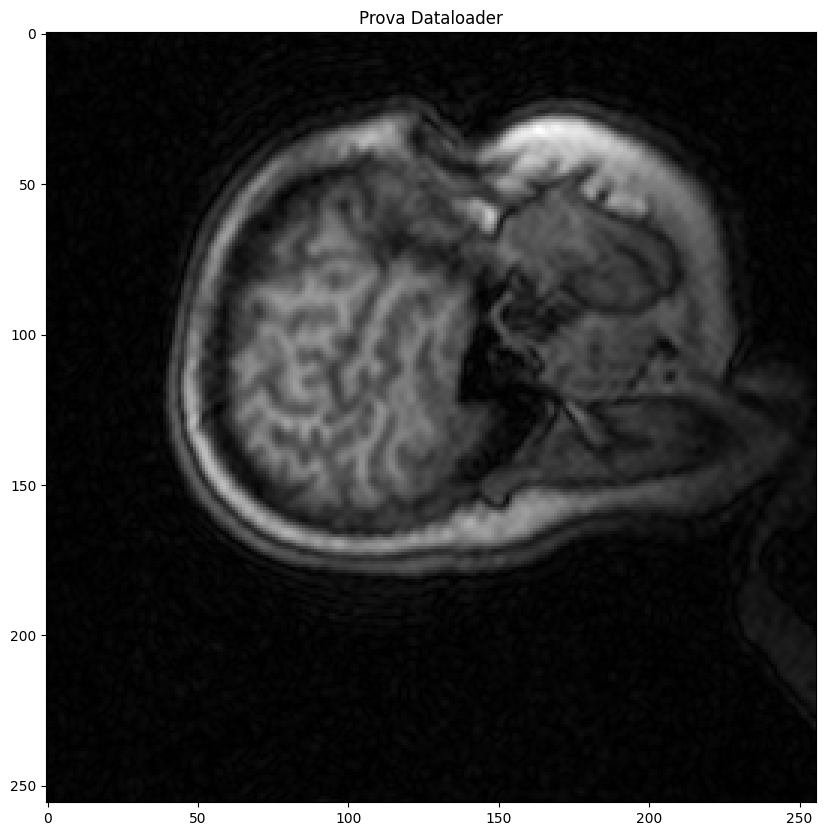

In [5]:
data.check_dataloader()

In [6]:
y_train = data.get_label()
class_weight = torch.tensor(compute_class_weight("balanced",classes = np.unique(y_train),y=y_train )).type(torch.float)

In [7]:
lr = 1e-5
loss_function = CrossEntropyLoss(weight=class_weight)

In [8]:
from typing import Any
import lightning as L
from lightning.pytorch.utilities.types import STEP_OUTPUT
import monai
from numpy import average
import torch
import torchmetrics


class SequenceClassification(L.LightningModule) : 

    def __init__(self,loss_function,learning_rate) : 
        super().__init__()
        self.__model = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=1, out_channels=4,pretrained = True)
        self.learning_rate = learning_rate
        self.loss_function = loss_function

        metrics = torchmetrics.MetricCollection([
            torchmetrics.Specificity(task="multiclass",num_classes=4),
            torchmetrics.Accuracy(task="multiclass",num_classes=4),
            torchmetrics.AUROC(task="multiclass",num_classes=4),
            torchmetrics.Recall(task="multiclass",num_classes=4)
            ])

        self.__train_metrics = metrics.clone(prefix="train_")
        self.__val_metrics = metrics.clone(prefix="val_")
    
    def forward(self,x) -> Any:
        return self.__model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(),lr = self.learning_rate,weight_decay=0.01 )
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,start_factor=0.5,end_factor=1,last_epoch=-1)
        return  [optimizer],[scheduler]
    
    def training_step(self, batch,batch_idx) -> STEP_OUTPUT:
        X,y = batch["img"],batch["label"]
        output = self.__model(X)
        loss = self.loss_function(output,y)
        self.log("Training Loss",loss ,on_step = False, on_epoch = True, prog_bar  =True)
        outputs = torch.stack([monai.transforms.Activations(softmax=True)(i) for i in monai.data.decollate_batch(output,detach = False)])
        #y_one_hot = torch.nn.functional.one_hot(y.to(torch.int64), num_classes=4) 
        self.__train_metrics.update(torch.as_tensor(outputs), y)  ## non va bene la codifica one-hot #TODO indagare su questo punto
        return loss
    
    def validation_step(self, batch,batch_idx) -> STEP_OUTPUT:
        X,y = batch["img"],batch["label"]
        output = self.__model(X)
        loss = self.loss_function(output,y)
        self.log("Validation Loss", loss, on_step = False, on_epoch = True, prog_bar  =True)
        outputs = torch.stack([monai.transforms.Activations(softmax=True)(i) for i in monai.data.decollate_batch(output,detach = False)])
        #y_one_hot = torch.nn.functional.one_hot(y.to(torch.int64), num_classes=4) 
        self.__val_metrics.update(torch.as_tensor(outputs), y)
    
        return loss
    
    def on_train_epoch_end(self):
        log_output = self.__train_metrics.compute()
        self.log_dict(log_output)
        self.__train_metrics.reset()
        
    def on_validation_epoch_end(self):
        log_output = self.__val_metrics.compute()
        self.log_dict(log_output)
        self.__val_metrics.reset()

In [9]:
model = SequenceClassification(loss_function,lr)

In [10]:
model_version = neptune.init_model_version(
    model="SEQCLAS-A",
    project="marioverd/SequenceClassification",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MjRhMWVmZC0xMzhiLTQ4YzAtYjE4ZS0zNTlkOGJjOTkzNWEifQ==", # your credentials
)

https://app.neptune.ai/marioverd/SequenceClassification/m/SEQCLAS-A/v/SEQCLAS-A-4


In [11]:
model_version["model"].upload("./LightningModule/ModelModule.py")

In [12]:

save_dir  = "./log/BrainNoBrain"
model_name = model.__class__.__name__
logger = TensorBoardLogger(save_dir = save_dir, name=model_name,flush_secs=10)
neptune_logger = NeptuneLogger(
    project="marioverd/SequenceClassification",
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MjRhMWVmZC0xMzhiLTQ4YzAtYjE4ZS0zNTlkOGJjOTkzNWEifQ==",
    log_model_checkpoints=False,
)

In [16]:
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(monitor = "val_MulticlassAUROC",verbose=True,mode= "max",save_weights_only=True,auto_insert_metric_name = True)
early_stop_callback = L.pytorch.callbacks.EarlyStopping(monitor="Validation Loss",patience=10, verbose=True, mode="min")


In [17]:
trainer = L.Trainer( logger = [logger,neptune_logger],
                    max_epochs = 100,
                    accelerator = "cuda",
                    deterministic=True ,
                    check_val_every_n_epoch = 1,
                    log_every_n_steps =26,
                    callbacks = [checkpoint_callback,early_stop_callback]
                    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model,data)

Loading dataset: 100%|██████████| 1076/1076 [00:54<00:00, 19.85it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                                   | Type             | Params
----------------------------------------------------------------------------
0 | _SequenceClassification__model         | DenseNet121      | 7.0 M 
1 | loss_function                          | CrossEntropyLoss | 0     
2 | _SequenceClassification__train_metrics | MetricCollection | 0     
3 | _SequenceClassification__val_metrics   | MetricCollection | 0     
----------------------------------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.807    Total estimated model params size (MB)


You are trying to use a metric in deterministic mode on GPU that uses `torch.cumsum`, which is currently not supported. The tensor will be copied to the CPU memory to compute it and then copied back to GPU. Expect some slowdowns.


Epoch 0: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s, v_num=AS-7, Validation Loss=0.990, Training Loss=0.933]

Metric Validation Loss improved. New best score: 0.990
Epoch 0, global step 68: 'val_MulticlassAUROC' reached 0.88698 (best 0.88698), saving model to './log/BrainNoBrain/SequenceClassification/version_5/checkpoints/epoch=0-step=68.ckpt' as top 1


Epoch 1: 100%|██████████| 68/68 [01:04<00:00,  1.05it/s, v_num=AS-7, Validation Loss=0.862, Training Loss=0.718]

Metric Validation Loss improved by 0.128 >= min_delta = 0.0. New best score: 0.862
Epoch 1, global step 136: 'val_MulticlassAUROC' reached 0.91674 (best 0.91674), saving model to './log/BrainNoBrain/SequenceClassification/version_5/checkpoints/epoch=1-step=136.ckpt' as top 1


Epoch 2: 100%|██████████| 68/68 [01:05<00:00,  1.04it/s, v_num=AS-7, Validation Loss=0.762, Training Loss=0.554]

Metric Validation Loss improved by 0.100 >= min_delta = 0.0. New best score: 0.762
Epoch 2, global step 204: 'val_MulticlassAUROC' reached 0.93448 (best 0.93448), saving model to './log/BrainNoBrain/SequenceClassification/version_5/checkpoints/epoch=2-step=204.ckpt' as top 1


Epoch 3: 100%|██████████| 68/68 [01:04<00:00,  1.06it/s, v_num=AS-7, Validation Loss=0.674, Training Loss=0.436]

Metric Validation Loss improved by 0.088 >= min_delta = 0.0. New best score: 0.674
Epoch 3, global step 272: 'val_MulticlassAUROC' reached 0.94712 (best 0.94712), saving model to './log/BrainNoBrain/SequenceClassification/version_5/checkpoints/epoch=3-step=272.ckpt' as top 1


Epoch 4: 100%|██████████| 68/68 [01:04<00:00,  1.05it/s, v_num=AS-7, Validation Loss=0.612, Training Loss=0.348]

Metric Validation Loss improved by 0.062 >= min_delta = 0.0. New best score: 0.612
Epoch 4, global step 340: 'val_MulticlassAUROC' reached 0.95428 (best 0.95428), saving model to './log/BrainNoBrain/SequenceClassification/version_5/checkpoints/epoch=4-step=340.ckpt' as top 1


Epoch 5: 100%|██████████| 68/68 [01:04<00:00,  1.05it/s, v_num=AS-7, Validation Loss=0.566, Training Loss=0.284]

Metric Validation Loss improved by 0.046 >= min_delta = 0.0. New best score: 0.566
Epoch 5, global step 408: 'val_MulticlassAUROC' reached 0.95984 (best 0.95984), saving model to './log/BrainNoBrain/SequenceClassification/version_5/checkpoints/epoch=5-step=408.ckpt' as top 1


Epoch 6: 100%|██████████| 68/68 [01:05<00:00,  1.04it/s, v_num=AS-7, Validation Loss=0.537, Training Loss=0.232]

Metric Validation Loss improved by 0.029 >= min_delta = 0.0. New best score: 0.537
Epoch 6, global step 476: 'val_MulticlassAUROC' reached 0.96377 (best 0.96377), saving model to './log/BrainNoBrain/SequenceClassification/version_5/checkpoints/epoch=6-step=476.ckpt' as top 1


Epoch 7: 100%|██████████| 68/68 [01:05<00:00,  1.04it/s, v_num=AS-7, Validation Loss=0.499, Training Loss=0.199]

Metric Validation Loss improved by 0.038 >= min_delta = 0.0. New best score: 0.499
Epoch 7, global step 544: 'val_MulticlassAUROC' reached 0.96772 (best 0.96772), saving model to './log/BrainNoBrain/SequenceClassification/version_5/checkpoints/epoch=7-step=544.ckpt' as top 1


Epoch 8: 100%|██████████| 68/68 [01:10<00:00,  0.97it/s, v_num=AS-7, Validation Loss=0.469, Training Loss=0.170]

Metric Validation Loss improved by 0.030 >= min_delta = 0.0. New best score: 0.469
Epoch 8, global step 612: 'val_MulticlassAUROC' reached 0.97046 (best 0.97046), saving model to './log/BrainNoBrain/SequenceClassification/version_5/checkpoints/epoch=8-step=612.ckpt' as top 1


Epoch 9: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s, v_num=AS-7, Validation Loss=0.442, Training Loss=0.148]

Metric Validation Loss improved by 0.027 >= min_delta = 0.0. New best score: 0.442
Epoch 9, global step 680: 'val_MulticlassAUROC' reached 0.97297 (best 0.97297), saving model to './log/BrainNoBrain/SequenceClassification/version_5/checkpoints/epoch=9-step=680.ckpt' as top 1


Epoch 10: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s, v_num=AS-7, Validation Loss=0.443, Training Loss=0.129]

Epoch 10, global step 748: 'val_MulticlassAUROC' reached 0.97352 (best 0.97352), saving model to './log/BrainNoBrain/SequenceClassification/version_5/checkpoints/epoch=10-step=748.ckpt' as top 1


Epoch 11: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s, v_num=AS-7, Validation Loss=0.430, Training Loss=0.114]

Metric Validation Loss improved by 0.012 >= min_delta = 0.0. New best score: 0.430
Epoch 11, global step 816: 'val_MulticlassAUROC' reached 0.97418 (best 0.97418), saving model to './log/BrainNoBrain/SequenceClassification/version_5/checkpoints/epoch=11-step=816.ckpt' as top 1


Epoch 12: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s, v_num=AS-7, Validation Loss=0.404, Training Loss=0.106]

Metric Validation Loss improved by 0.026 >= min_delta = 0.0. New best score: 0.404
Epoch 12, global step 884: 'val_MulticlassAUROC' reached 0.97625 (best 0.97625), saving model to './log/BrainNoBrain/SequenceClassification/version_5/checkpoints/epoch=12-step=884.ckpt' as top 1


Epoch 13: 100%|██████████| 68/68 [01:03<00:00,  1.07it/s, v_num=AS-7, Validation Loss=0.411, Training Loss=0.0898]

Epoch 13, global step 952: 'val_MulticlassAUROC' reached 0.97669 (best 0.97669), saving model to './log/BrainNoBrain/SequenceClassification/version_5/checkpoints/epoch=13-step=952.ckpt' as top 1


Epoch 14: 100%|██████████| 68/68 [01:04<00:00,  1.06it/s, v_num=AS-7, Validation Loss=0.420, Training Loss=0.0823]

Epoch 14, global step 1020: 'val_MulticlassAUROC' was not in top 1


Epoch 15: 100%|██████████| 68/68 [01:04<00:00,  1.05it/s, v_num=AS-7, Validation Loss=0.398, Training Loss=0.0768]

Metric Validation Loss improved by 0.006 >= min_delta = 0.0. New best score: 0.398
Epoch 15, global step 1088: 'val_MulticlassAUROC' reached 0.97777 (best 0.97777), saving model to './log/BrainNoBrain/SequenceClassification/version_5/checkpoints/epoch=15-step=1088.ckpt' as top 1


Epoch 16: 100%|██████████| 68/68 [01:07<00:00,  1.00it/s, v_num=AS-7, Validation Loss=0.403, Training Loss=0.0653]

Epoch 16, global step 1156: 'val_MulticlassAUROC' was not in top 1


Epoch 17: 100%|██████████| 68/68 [01:06<00:00,  1.03it/s, v_num=AS-7, Validation Loss=0.423, Training Loss=0.0624]

Epoch 17, global step 1224: 'val_MulticlassAUROC' was not in top 1


Epoch 18: 100%|██████████| 68/68 [01:06<00:00,  1.02it/s, v_num=AS-7, Validation Loss=0.387, Training Loss=0.0602]

Metric Validation Loss improved by 0.010 >= min_delta = 0.0. New best score: 0.387
Epoch 18, global step 1292: 'val_MulticlassAUROC' was not in top 1


Epoch 19: 100%|██████████| 68/68 [01:04<00:00,  1.05it/s, v_num=AS-7, Validation Loss=0.401, Training Loss=0.050] 

Epoch 19, global step 1360: 'val_MulticlassAUROC' was not in top 1


Epoch 20: 100%|██████████| 68/68 [01:05<00:00,  1.04it/s, v_num=AS-7, Validation Loss=0.381, Training Loss=0.0432]

Metric Validation Loss improved by 0.007 >= min_delta = 0.0. New best score: 0.381
Epoch 20, global step 1428: 'val_MulticlassAUROC' was not in top 1


Epoch 21: 100%|██████████| 68/68 [01:04<00:00,  1.05it/s, v_num=AS-7, Validation Loss=0.379, Training Loss=0.0408]

Metric Validation Loss improved by 0.002 >= min_delta = 0.0. New best score: 0.379
Epoch 21, global step 1496: 'val_MulticlassAUROC' was not in top 1


Epoch 22: 100%|██████████| 68/68 [01:05<00:00,  1.04it/s, v_num=AS-7, Validation Loss=0.390, Training Loss=0.0357]

Epoch 22, global step 1564: 'val_MulticlassAUROC' was not in top 1


Epoch 23: 100%|██████████| 68/68 [01:03<00:00,  1.06it/s, v_num=AS-7, Validation Loss=0.421, Training Loss=0.0293]

Epoch 23, global step 1632: 'val_MulticlassAUROC' was not in top 1


Epoch 24: 100%|██████████| 68/68 [01:04<00:00,  1.06it/s, v_num=AS-7, Validation Loss=0.397, Training Loss=0.0261]

Epoch 24, global step 1700: 'val_MulticlassAUROC' was not in top 1


Epoch 25: 100%|██████████| 68/68 [01:04<00:00,  1.05it/s, v_num=AS-7, Validation Loss=0.404, Training Loss=0.0265]

Epoch 25, global step 1768: 'val_MulticlassAUROC' was not in top 1


Epoch 26: 100%|██████████| 68/68 [01:03<00:00,  1.07it/s, v_num=AS-7, Validation Loss=0.374, Training Loss=0.021] 

Metric Validation Loss improved by 0.005 >= min_delta = 0.0. New best score: 0.374
Epoch 26, global step 1836: 'val_MulticlassAUROC' reached 0.97906 (best 0.97906), saving model to './log/BrainNoBrain/SequenceClassification/version_5/checkpoints/epoch=26-step=1836.ckpt' as top 1


Epoch 27: 100%|██████████| 68/68 [01:04<00:00,  1.06it/s, v_num=AS-7, Validation Loss=0.402, Training Loss=0.0192]

Epoch 27, global step 1904: 'val_MulticlassAUROC' was not in top 1


Epoch 28: 100%|██████████| 68/68 [01:03<00:00,  1.06it/s, v_num=AS-7, Validation Loss=0.391, Training Loss=0.0181]

Epoch 28, global step 1972: 'val_MulticlassAUROC' was not in top 1


Epoch 29: 100%|██████████| 68/68 [01:04<00:00,  1.06it/s, v_num=AS-7, Validation Loss=0.441, Training Loss=0.0179]

Epoch 29, global step 2040: 'val_MulticlassAUROC' was not in top 1


Epoch 30: 100%|██████████| 68/68 [01:03<00:00,  1.07it/s, v_num=AS-7, Validation Loss=0.420, Training Loss=0.0141]

Epoch 30, global step 2108: 'val_MulticlassAUROC' was not in top 1


Epoch 31: 100%|██████████| 68/68 [01:04<00:00,  1.06it/s, v_num=AS-7, Validation Loss=0.410, Training Loss=0.0129]

Epoch 31, global step 2176: 'val_MulticlassAUROC' was not in top 1


Epoch 32: 100%|██████████| 68/68 [01:03<00:00,  1.08it/s, v_num=AS-7, Validation Loss=0.433, Training Loss=0.0151]

Epoch 32, global step 2244: 'val_MulticlassAUROC' was not in top 1


Epoch 33: 100%|██████████| 68/68 [01:05<00:00,  1.04it/s, v_num=AS-7, Validation Loss=0.423, Training Loss=0.0144]

Epoch 33, global step 2312: 'val_MulticlassAUROC' was not in top 1


Epoch 34: 100%|██████████| 68/68 [01:03<00:00,  1.07it/s, v_num=AS-7, Validation Loss=0.410, Training Loss=0.010] 

Epoch 34, global step 2380: 'val_MulticlassAUROC' was not in top 1


Epoch 35: 100%|██████████| 68/68 [01:03<00:00,  1.06it/s, v_num=AS-7, Validation Loss=0.403, Training Loss=0.00743]

Epoch 35, global step 2448: 'val_MulticlassAUROC' was not in top 1


Epoch 36: 100%|██████████| 68/68 [01:03<00:00,  1.07it/s, v_num=AS-7, Validation Loss=0.415, Training Loss=0.00849]

Monitored metric Validation Loss did not improve in the last 10 records. Best score: 0.374. Signaling Trainer to stop.
Epoch 36, global step 2516: 'val_MulticlassAUROC' was not in top 1


Epoch 36: 100%|██████████| 68/68 [01:03<00:00,  1.07it/s, v_num=AS-7, Validation Loss=0.415, Training Loss=0.00849]
